# Introduction to `rasterio` and `atlite`

In this tutorial, we're going to cover two new Python packages:

**Rasterio: access to geospatial raster data**

> Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

:::{note}
Documentation for rasterio is available at https://rasterio.readthedocs.io/en/latest/index.html.
:::

**Atlite: Convert weather data to energy systems data**

> Atlite is a free software, xarray-based Python library for converting weather data (such as wind speeds, solar radiation, temperature and runoff) into power systems data (such as wind power, solar power, hydro power and heating demand time series).

:::{note}
Documentation for atlite is available at https://atlite.readthedocs.io/en/latest/.

This tool is developed here at TU Berlin in the group of Digital Transformation of Energy Systems.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install atlite rasterio geopandas cartopy matplotlib numpy xarray
```
:::



## Download of Required Data

Before we can run this tutorial, we have to download a few input data files to your local filesystem. The cell below uses some Python utility packages to automate the retrieval of the required files.

In [12]:
from urllib.request import urlretrieve
from os.path import basename

url = (
    "https://tubcloud.tu-berlin.de/s/2oogpgBfM5n4ssZ/download/PORTUGAL-2013-01-era5.nc"
)
urlretrieve(url, basename(url))

('PORTUGAL-2013-01-era5.nc', <http.client.HTTPMessage at 0x2895030d0>)

## Repetition of Vector Data

In the last tutorial, we used `geopandas` to work with **vector data** (e.g. points, lines, polygons):

Importing the package:

In [13]:
import geopandas as gpd

Reading the file:

In [14]:
url = "https://tubcloud.tu-berlin.de/s/7bpHrAkjMT3ADSr/download/country_shapes.geojson"

In [15]:
countries = gpd.read_file(url).set_index("name")

Inspecting the GeoDataFrame:

In [16]:
countries

,geometry
name,
AE,"MULTIPOLYGON (((56.34002 25.60456, 56.34799 25..."
AF,"POLYGON ((74.54235 37.02167, 74.54742 37.01567..."
AL,"POLYGON ((20.56715 41.87318, 20.54172 41.86158..."
AM,"POLYGON ((45.03940 41.23118, 45.02932 41.21010..."
AO,"MULTIPOLYGON (((23.98058 -10.93835, 24.00001 -..."
...,...
VN,"MULTIPOLYGON (((107.49807 14.74595, 107.50928 ..."
YE,"MULTIPOLYGON (((52.09954 18.72304, 52.14233 18..."
ZA,"MULTIPOLYGON (((19.99292 -24.77585, 20.01049 -..."


In [17]:
countries.tail()

,geometry
name,
VN,"MULTIPOLYGON (((107.49807 14.74595, 107.50928 ..."
YE,"MULTIPOLYGON (((52.09954 18.72304, 52.14233 18..."
ZA,"MULTIPOLYGON (((19.99292 -24.77585, 20.01049 -..."
ZM,"POLYGON ((32.92086 -9.40790, 32.92303 -9.46629..."
ZW,"POLYGON ((25.25978 -17.79411, 25.26671 -17.800..."


:::{note}
This dataset uses ISO-2 country codes as index: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2.
:::

Plotting the GeoDataFrame:

<Axes: >

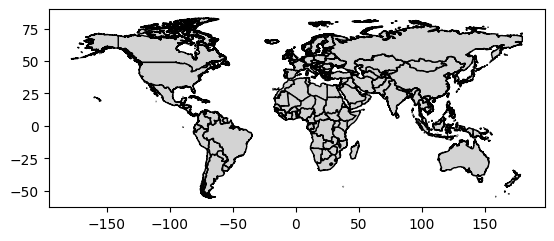

In [18]:
countries.plot(edgecolor="k", facecolor="lightgrey")

# Note: Automatically looks for "geometry" column


Reprojecting geometries in the GeoDataFrame:

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

<GeoAxes: >

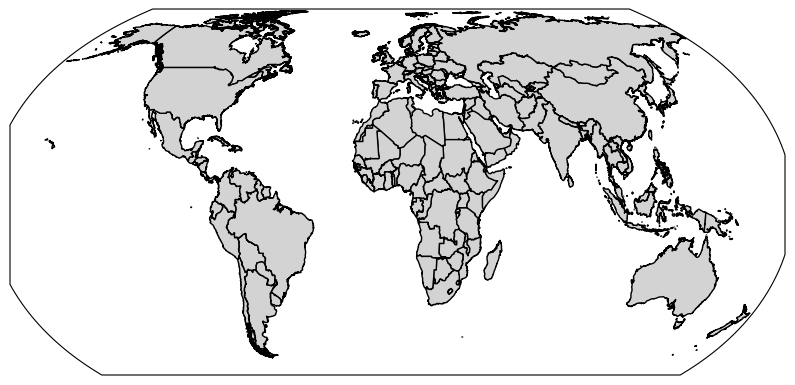

In [21]:
crs = ccrs.EqualEarth() # Specifies shape of the world.
# crs = Coordinate Reference System

fig = plt.figure(figsize=(10, 5))

ax = plt.axes(projection=crs)

countries.to_crs(crs.proj4_init).plot(ax=ax, edgecolor="k", facecolor="lightgrey")

# Note: crs.proj4_init returns a "Proj4" string representation of the crs.
# https://pygis.io/docs/d_understand_crs_codes.html

In [22]:
# Note: Just me trying some random things.
# ccrs.EckertI()
# ccrs.EckertVI()
# ccrs.EquidistantConic()

## Raster Data with `rasterio`

But we haven't worked with **raster data** yet!

One useful package for working with raster data is [`rasterio`](https://rasterio.readthedocs.io/en/latest/):

In [23]:
import rasterio

With `rasterio`, we can for instance load GeoTIFF files.

In the example below, we load the [CORINE land cover classification](https://land.copernicus.eu/pan-european/corine-land-cover) for Portugal:



In [24]:
url = "https://tubcloud.tu-berlin.de/s/Mw5dwbwdsDY8zfH/download/U2018_CLC2018_V2020_20u1-PT.tif"
clc = rasterio.open(url) 

# tif is a type of image

Datasets can have one or more bands (or layers), which can be read with the `.read()` function:

In [25]:
band = clc.read(1)

In [26]:
band

array([[-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       ...,
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128],
       [-128, -128, -128, ..., -128, -128, -128]], dtype=int8)

The returned object is a 2-dimensional `numpy.ndarray`. 

In [27]:
type(band)

numpy.ndarray

In [28]:
band.shape

(5662, 3404)

The band values correspond to a land cover and land use classification scheme with class values as listed [here](https://collections.sentinel-hub.com/corine-land-cover/readme.html).

This is an example of **categorical values** in raster data.

In [29]:
import numpy as np

In [30]:
np.unique(band)

# Show what a band is here: https://collections.sentinel-hub.com/corine-land-cover/readme.html

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   35,   37,   38,   39,   40,   41,   42,   43,   44],
      dtype=int8)

There are two common options to plot raster data:
- with `plt.imshow()`
- with `rasterio.plot.show()`

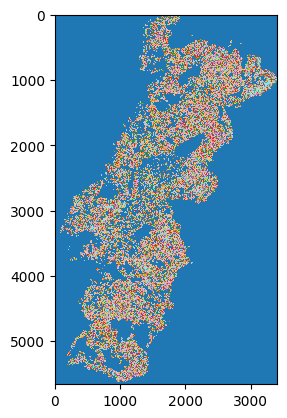

In [100]:
plt.imshow(band, cmap="tab20")

# cmap?

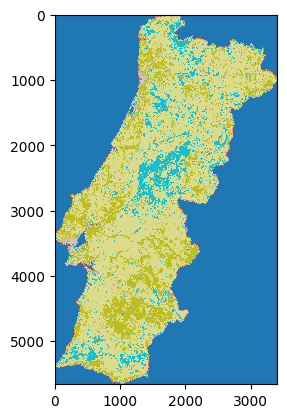

<Axes: >

In [32]:
from rasterio.plot import show

show(band, cmap="tab20")


The integrated `rasterio` plotting functionality is slightly more powerful.

For instance, it can label the axes with proper geo-referenced extents.

These are stored in the `.crs`, `.bounds` and `.transform` attributes.

In [101]:
clc.crs

CRS.from_epsg(3035)

In [102]:
clc.bounds

# what are these numbers in reference to?

# according to chatgpt:
# """
# Here's a brief explanation of each value in the tuple:

# left: The minimum x-coordinate (longitude in a geographic CRS or easting in a projected CRS) of the bounding box.
# bottom: The minimum y-coordinate (latitude in a geographic CRS or northing in a projected CRS) of the bounding box.
# right: The maximum x-coordinate of the bounding box.
# top: The maximum y-coordinate of the bounding box.
# """

BoundingBox(left=2635400.0, bottom=1732500.0, right=2975800.0, top=2298700.0)

In [103]:
clc.transform

# ???

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can pass the information on the projection to the `rasterio.plot.show()` function:

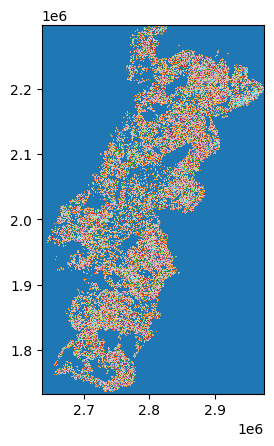

<Axes: >

In [104]:
from rasterio.plot import show

show(band, transform=clc.transform, cmap="tab20")

Let's quickly load another dataset with **continuous values**: The elevation and water depth in and around Portugal.

This dataset comes from [GEBCO Gridded Bathymetry Data](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) and has another file format `.nc` (netCDF) which also stores raster data.

It would be useful to exclude very mountainous areas, or identify shallow water at sea for the development of offshore wind turbines.

In [105]:
url = "https://tubcloud.tu-berlin.de/s/XoDpBcweJHmYKgF/download/GEBCO_2014_2D-PT.nc"
gebco = rasterio.open(url)

/Users/nicholasabad/miniconda3/envs/esm/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [106]:
band = gebco.read(1)

In [107]:
np.unique(band)

array([-2898, -2862, -2856, ...,  1915,  1926,  1959], dtype=int16)

For plotting, we can also display **vector and raster data together**:

<Axes: >

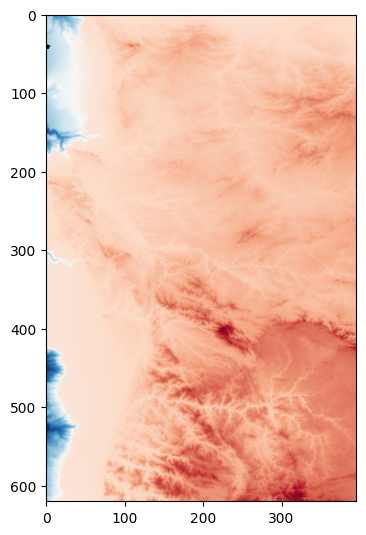

In [108]:
fig, ax = plt.subplots(figsize=(4, 8))

countries.loc[["PT", "ES"]].plot(ax=ax, color="none")

show(band, transform=gebco.transform, cmap="RdBu_r", ax=ax)

## Land Eligibility Analysis with `atlite`

To estimate the wind and solar generation potential of a country, land usage constraints need to be taken into account.

Data required to determine the eligible areas is stored as **raster** and **vector** data.

**Examples:**

- **Vector Data:** natural protection areas, settlements, roads, airports
- **Raster Data:** type of land, elevation, slope

The [`atlite`](https://atlite.readthedocs.io) library has some useful features to handle exclusion constraints for both datatypes.

The core object to do land elibility analysis in `atlite` is the `ExclusionContainer`, which serves as a container for all rasters and geometries we want to exclude (or include).

In [41]:
from atlite.gis import ExclusionContainer

In many cases, rasters and geometries have different projections and resolutions. Therefore, the `ExclusionContainer` is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is [3035](https://epsg.io/3035) and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this CRS and resolution.

:::{warning}
The [CRS 3035](https://epsg.io/3035) is only valid in Europe.
:::

In [112]:
excluder = ExclusionContainer(crs=3035)

In [113]:
excluder

Exclusion Container
 registered rasters: 0 
 registered geometry collections: 0
 CRS: 3035 - Resolution: 100

Let's add our first exclusion criteria, the [Natura2000 natural protection areas](https://www.google.com/search?channel=fs&client=ubuntu&q=natura200), to the container using the `excluder.add_geometry()` function. This function is for vector data. It's sibling, `excluder.add_raster()` we will use later.

In [114]:
url = "https://tubcloud.tu-berlin.de/s/mxgaA7wH8NsmdDi/download/Natura2000_end2021-PT.gpkg"
excluder.add_geometry(url)

In [115]:
excluder

# Excluder: Container of all meta data or objects which to exclude, i.e. rasters and geometries.

Exclusion Container
 registered rasters: 0 
 registered geometry collections: 1
 CRS: 3035 - Resolution: 100

To calculate the *mask* for the exclusion container (i.e. which cells are not excluded), we can use the `shape_availability()` function, which takes as arguments:
- a **geometry** (e.g. country shape) within which to calculate available areas
- an **exclusion container** object

In [46]:
from atlite.gis import shape_availability

Since the excluder is in `crs=3035`, we should also convert to geometry of Portucal to `excluder.crs` first.

/Users/nicholasabad/miniconda3/envs/esm/lib/python3.11/site-packages/geopandas/geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


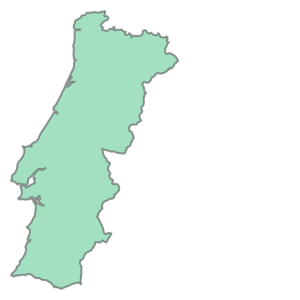

In [48]:
shape = countries.to_crs(excluder.crs).loc[["PT"]].geometry
shape[0]

We can then call the `shape_availability` function:

In [128]:
1 == True


True

In [130]:
0 == True

False

In [131]:
import numpy as np

some_list = [0,1,1,0,1]

np.sum(some_list)

3

In [132]:
some_list_2 = [False, True, True, False, True]
np.sum(some_list_2)

3

In [117]:
band, transform = shape_availability(shape, excluder)

# shape_availability: Compute the eligible area in one or more geometries.
# corresponds to the areas that are available
print(band)
print(transform)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
| 100.00, 0.00, 2635400.00|
| 0.00,-100.00, 2298700.00|
| 0.00, 0.00, 1.00|


This function returns a 2-D `numpy.ndarray` and a transformation, similar to the previous `rasterio` examples.

Eligile raster cells have a `True` and excluded cells a `False`.

In [118]:
band

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [119]:
band.any()

True

In [120]:
transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can use the `rasterio.plot.show()` function for plotting:

<Axes: >

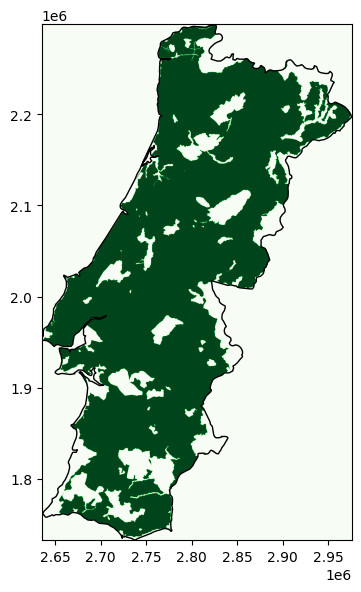

In [124]:
fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax)

# green represents where we could go

How to calculate what share of the land is eligible?
1. count number of eligible raster cells
2. determine area per raster cell
3. multiply cell area with number of cells
4. divide eligible area by total land area

In [59]:
eligible_cells = band.sum()
# Count all Trues and Falses of available areas

In [133]:
eligible_cells

7005385

In [62]:
cell_area = excluder.res**2
# get the area per raster cell


100

In [67]:
eligible_area = cell_area * eligible_cells

In [134]:
eligible_area

70053850000

In [68]:
country_area = shape.geometry.area[0]

/var/folders/2s/38kg81v526j7qcgd8gdq8jd00000gn/T/ipykernel_19930/1192973842.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  country_area = shape.geometry.area[0]


In [135]:
country_area

87952070844.79523

In [69]:
eligible_area / country_area * 100

79.65002907506367

In this example, approximately 20% of Portugal's land area are covered by nature reserves.

Typically, more than one dataset is needed for a proper land eligibility analysis, i.e. we need to add more datasets to our container.
So, let's expand the exclusion container ...

In [145]:
url = "https://tubcloud.tu-berlin.de/s/mxgaA7wH8NsmdDi/download/Natura2000_end2021-PT.gpkg"
excluder = ExclusionContainer()
excluder.add_geometry(url)

In [146]:
excluder

Exclusion Container
 registered rasters: 0 
 registered geometry collections: 1
 CRS: 3035 - Resolution: 100

... by a selection of CORINE land cover classes, which is given as raster data:

When adding a raster to the `ExclusionContainer` you can specify which **codes** (integers) to exclude.

By setting `invert=True`, you can also restrict the inclusion to a set of codes.

Furthermore, you can add a **buffer** around codes which should also be excluded.

Here we are first going to include a set of suitable [CORINE classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html):

In [147]:
fn = "https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/U2018_CLC2018_V2020_20u1-PT.tif"

In [148]:
codes = [12, 13, 18, 19, 20, 21]
# Look at the link

In [149]:
excluder.add_raster(fn, codes=codes, crs=3035, invert=True)

In [150]:
excluder

Exclusion Container
 registered rasters: 1 
 registered geometry collections: 1
 CRS: 3035 - Resolution: 100

And then we are going exclude [CORINE classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html) representing settled areas with an 800 meter buffer around them:

In [151]:
codes = [1, 2, 3, 4, 5, 6]

In [152]:
excluder.add_raster(fn, codes=codes, buffer=800, crs=3035)

In [153]:
excluder

Exclusion Container
 registered rasters: 2 
 registered geometry collections: 1
 CRS: 3035 - Resolution: 100

Then, we can simply repeat the calculation and visualisation of available cells:

<Axes: >

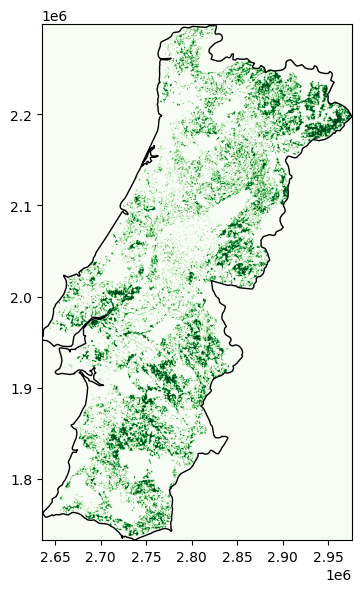

In [154]:
band, transform = shape_availability(shape, excluder)

# Excludes both rasters and geometry

fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax)

## Spatial and Temporal Availability

Besides calculating spatial potential for renewables development, [`atlite`](https://atlite.readthedocs.io) can also handle weather data time series and convert them to energy systems time series (like production time series for wind and solar).

One famous such dataset is the [ERA5 reanalysis data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) which has historical weather data for the whole world from 1959 to 2022 at hourly resolution and on a 0.25 x 0.25 degree grid (roughly 25-30 km depending on where you are).

`atlite` can be imported like this (usually without an alias):

In [81]:
import atlite

A cutout is the basis for any of your work and calculations and contains all the weather data.

Here, we load an existing dataset which was retrieved from `ERA5`.

In [155]:
cutout = atlite.Cutout("PORTUGAL-2013-01-era5.nc")

In [156]:
cutout

<Cutout "PORTUGAL-2013-01-era5">
 x = -9.90 ⟷ -6.00, dx = 0.30
 y = 36.00 ⟷ 42.90, dy = 0.30
 time = 2013-01-01 ⟷ 2013-02-01, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

Let's quickly plot the spatial resolution and scope of this dataset:

In [160]:
cutout.data

<xarray.Dataset>
Dimensions:           (x: 14, y: 24, time: 768)
Coordinates:
  * x                 (x) float64 -9.9 -9.6 -9.3 -9.0 ... -6.9 -6.6 -6.3 -6.0
  * y                 (y) float64 36.0 36.3 36.6 36.9 ... 42.0 42.3 42.6 42.9
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-02-01T23:00:00
    lon               (x) float64 dask.array<chunksize=(14,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(24,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(24, 14), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'runoff', 'temperature', 'wind', 'influx']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2022-03-04 14:08:37 GMT by grib_to_netcdf-2.24.2: /op...

<Axes: >

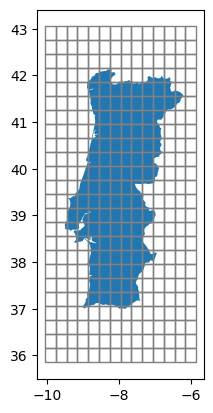

In [165]:
ax = shape.to_crs(4326).plot()
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

We can directly access, aggregate, and plot individual meteorological parameters:

In [168]:
temperature = cutout.data.temperature.mean(dim="time")

In [169]:
temperature

<xarray.DataArray 'temperature' (y: 24, x: 14)>
dask.array<mean_agg-aggregate, shape=(24, 14), dtype=float32, chunksize=(24, 14), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -9.9 -9.6 -9.3 -9.0 -8.7 ... -7.2 -6.9 -6.6 -6.3 -6.0
  * y        (y) float64 36.0 36.3 36.6 36.9 37.2 ... 41.7 42.0 42.3 42.6 42.9
    lon      (x) float64 dask.array<chunksize=(14,), meta=np.ndarray>
    lat      (y) float64 dask.array<chunksize=(24,), meta=np.ndarray>

<GeoAxes: xlabel='x', ylabel='y'>

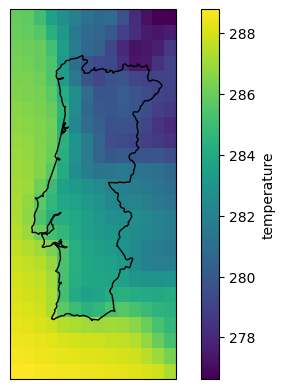

In [172]:
ax = plt.axes(projection=ccrs.PlateCarree())

temperature.plot(ax=ax)

shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")

This cutout happens to also have data on the surface roughness. We can use this to scale the 100 meter wind speeds down to 10 meters using the **log law**:

$$\frac{U(z)}{U(z_r)} = \frac{\ln\left(\frac{z}{z_0}\right)}{\ln\left(\frac{z_r}{z_0}\right)}$$

In [91]:
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m

In [92]:
wnd10m = wnd100m * np.log(10 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

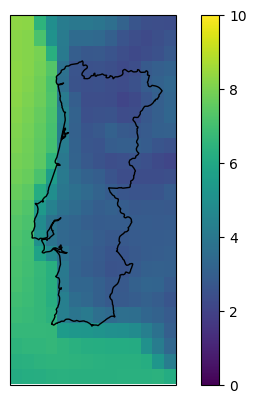

In [93]:
ax = plt.axes(projection=ccrs.PlateCarree())

wnd10m.mean(dim="time").plot(ax=ax, vmin=0, vmax=10)

shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")

We can also build means in the spatial dimensions and investigate the behaviour of meteorological variables over time. Here, we do this for the direct solar irradiation.

In [173]:
cutout.data

<xarray.Dataset>
Dimensions:           (x: 14, y: 24, time: 768)
Coordinates:
  * x                 (x) float64 -9.9 -9.6 -9.3 -9.0 ... -6.9 -6.6 -6.3 -6.0
  * y                 (y) float64 36.0 36.3 36.6 36.9 ... 42.0 42.3 42.6 42.9
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-02-01T23:00:00
    lon               (x) float64 dask.array<chunksize=(14,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(24,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(24, 14), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'runoff', 'temperature', 'wind', 'influx']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2022-03-04 14:08:37 GMT by grib_to_netcdf-2.24.2: /op...

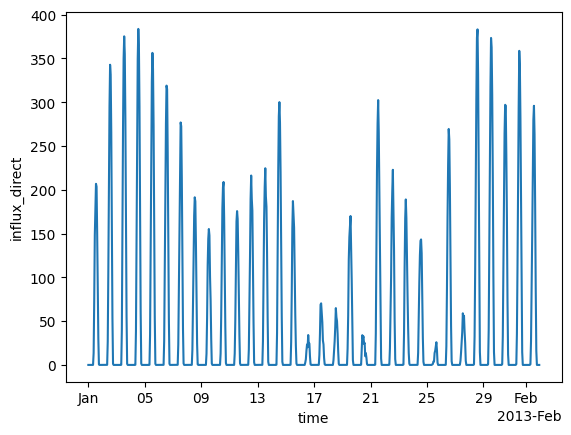

In [175]:
cutout.data.mean(dim=["x", "y"]).influx_direct.plot()

We also already saw that the weather cells are much larger than the raster cells. `atlite` automates this conversion for averaging fine-grained to coarse-grained rasters for all geometries in shapes when calling the `cutout.availabilitymatrix()` function. 

In [95]:
A = cutout.availabilitymatrix(shape, excluder)

Compute availability matrix: 100%|██████████| 1/1 [00:00<00:00,  1.12 gridcells/s]


`A` is an array with 3 dimensions (`shape`, `x`, `y`) and very sparse data. It indicates the relative overlap of weather cell (`x`, `y`) with geometry shape while excluding the area specified by the excluder.

<Axes: title={'center': 'name = PT'}, xlabel='x', ylabel='y'>

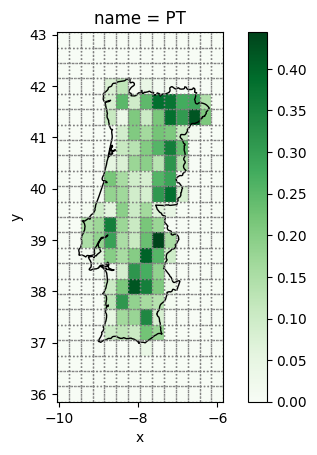

In [176]:
fig, ax = plt.subplots()
A.sel(name="PT").plot(cmap="Greens")
shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":")

The availibility matrix `A` can now be used as a layout matrix in the conversion functions of `atlite` from wind speeds to capacity factors.

The normal approach would be to weigh the availabilities with the area per grid cell and the capacity per area.

:::{note}
No worries, if this part of the code is a bit too complicated! We might touch on `xarray` a little later in the course.
:::

In [177]:
import xarray as xr

cap_per_sqkm = 2
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm

In [178]:
capacity_matrix

<xarray.DataArray (name: 1, spatial: 336)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.04501326e+01, 7.11966852e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.82239659e+02, 2.23278877e+02, 1.89298658e+02, 3.96195870e+02,
        3.13629979e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.17187909e+01, 2.93673350e+02,
        3.11089354e+02, 5.97719962e+02, 1.41888080e+02, 0.00000000e+00,
...
        1.84737059e+02, 5.67320769e+01, 3.48595298e+02, 1.69601550e+02,
        3.56955554e+02, 6.40409074e+02, 5.13274363e+02, 7.04472112e+02,
        3.56107101e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.38528139e+02, 4.14865366e+02,
        1.60953363e+02, 4.09544671e+02, 6.40558055e+02, 6.26165161e+02,
        4.56260591e+02, 4.65391083e+02, 2.37533144e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.27956984e+02, 2.03165756e+02, 1.15364627e+01, 6.61948490e+01,
        2.43254453e+01, 2.10043837e+01, 0.00000000e+00, 7.45877968e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * name     (name) object 'PT'
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 36.0 36.0 36.0 36.0 36.0 ... 42.9 42.9 42.9 42.9
  * x        (spatial) float64 -9.9 -9.6 -9.3 -9.0 -8.7 ... -6.9 -6.6 -6.3 -6.0

We can now calculate the capacity factor time series for Portugal.

In [179]:
cutout.prepare()
wind = cutout.wind(matrix=capacity_matrix, turbine="Vestas_V90_3MW", index=shape.index)

/Users/nicholasabad/miniconda3/envs/esm/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)


Finally, let’s see how the total wind power potential per region look.

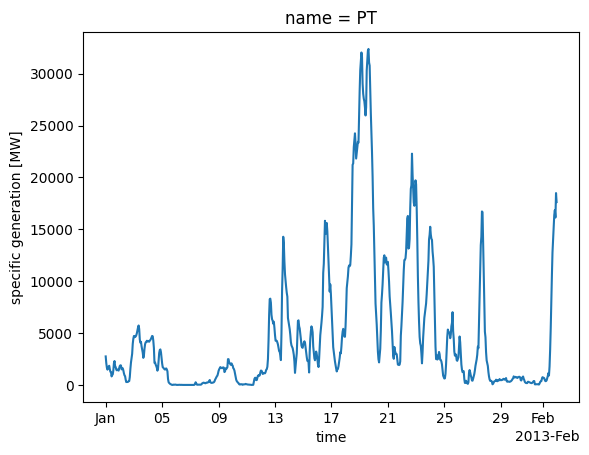

In [180]:
wind.plot()

## Exercises

Tweak some parameters of the land exclusion calculation:

- vary the CORINE land classes allower for wind turbine development
- vary the buffer distance and observe the change in availble area
- add the GEBCO topography data to the exclusion calculator and exclude areas above 1000 m